<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-Data" data-toc-modified-id="Import-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import Data</a></span></li><li><span><a href="#Bootstrap" data-toc-modified-id="Bootstrap-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Bootstrap</a></span></li><li><span><a href="#Do-EWS" data-toc-modified-id="Do-EWS-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Do EWS</a></span><ul class="toc-item"><li><span><a href="#STD" data-toc-modified-id="STD-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>STD</a></span></li><li><span><a href="#AR" data-toc-modified-id="AR-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>AR</a></span></li></ul></li></ul></div>

In [126]:
__author__ = "Louella Alva Presbitero"

In [127]:
import pandas as pd
import random

import sys
sys.path.append('../')

import matplotlib.pylab as plt

import burn
from burn.preprocess import *
from burn.model import *
from burn.utils import *
from burn.plot import *
from burn.parameters import *
from burn.ews import *

# Import Data

In [128]:
# import mars dataset
data = pd.read_csv('../data/MARS_luminex.csv')

# import survival
survive = pd.read_csv('../data/ICU_survival.csv')

In [129]:
# merge data
df = data.merge(survive[['ICU_ID_from_datasource',
                'death_in_ICU']], on='ICU_ID_from_datasource')



# get critical patients
df_critical = df[df['death_in_ICU'] == 1]

# get non-critical patients
df_non_critical = df[df['death_in_ICU'] == 0]

In [130]:
df_critical.head()

,Unnamed: 0,ICU_Admission_TK,ICU_ID_from_datasource,Assessment_Dates_TK,days_since_admission,Neutrophils,AF_Max,CRP_Max,White_cell_count_Max,PG.ML.A7.IL6,LLOD.A7.IL6,LLOQ.A7.IL6,PG.ML.B7.IL10,LLOD.B7.IL10,LLOQ.B7.IL10,death_in_ICU
49,50,1033,7507,NaN,0,NaN,NaN,126.0,12.5,NaN,NaN,NaN,NaN,NaN,NaN,1
50,51,1033,7507,1126.0,1,12.0,96.0,157.0,12.5,NaN,NaN,NaN,NaN,NaN,NaN,1
51,52,1033,7507,1127.0,2,NaN,102.0,295.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,1
52,53,1033,7507,1128.0,3,NaN,78.0,221.0,9.6,NaN,NaN,NaN,NaN,NaN,NaN,1
53,54,1033,7507,1129.0,4,NaN,84.0,304.0,10.3,NaN,NaN,NaN,NaN,NaN,NaN,1


In [131]:
df_non_critical.head()

,Unnamed: 0,ICU_Admission_TK,ICU_ID_from_datasource,Assessment_Dates_TK,days_since_admission,Neutrophils,AF_Max,CRP_Max,White_cell_count_Max,PG.ML.A7.IL6,LLOD.A7.IL6,LLOQ.A7.IL6,PG.ML.B7.IL10,LLOD.B7.IL10,LLOQ.B7.IL10,death_in_ICU
0,1,1004,7461,NaN,0,NaN,NaN,11.0,15.9,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2,1004,7461,1008.0,1,NaN,93.0,16.0,15.9,NaN,NaN,NaN,NaN,NaN,NaN,0
2,3,1004,7461,1009.0,2,NaN,NaN,144.0,10.6,NaN,NaN,NaN,NaN,NaN,NaN,0
3,4,1004,7461,1010.0,3,NaN,NaN,404.0,10.8,NaN,NaN,NaN,NaN,NaN,NaN,0
4,5,1004,7461,1011.0,4,NaN,NaN,248.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,0


# Bootstrap

In [132]:
cells = ['White_cell_count_Max', 'Neutrophils',
         'CRP_Max', 'PG.ML.A7.IL6', 'PG.ML.B7.IL10', 'AF_Max']
to_drop = ['Unnamed: 0', 'ICU_Admission_TK',
           'Assessment_Dates_TK', 'death_in_ICU', 'LLOD.A7.IL6', 'LLOQ.A7.IL6', 'LLOD.B7.IL10', 'LLOQ.B7.IL10']

time = 'days_since_admission'
patient = 'ICU_ID_from_datasource'

dic = {
    'White_cell_count_Max': 'WBC',
    'Neutrophils': 'Neutrophils',
    'CRP_Max': 'CRP',
    'PG.ML.A7.IL6': 'IL6',
    'PG.ML.B7.IL10': 'IL10',
    'AF_Max': 'AP'
}

In [133]:
def drop_columns(df, to_drop):
    """
    Drops columns from dataframe
    
    Args:
    
    Returns:
    
    """
    return df.drop(to_drop, axis=1).reset_index(drop=True)

In [134]:
def rename(df, dic):
    """
    Rename dataframe
    
    Args:
        df: DataFrame
        dic: Dictionary
    
    Returns:
        
    """
    return df.rename(dic, axis=1)  # new method

In [135]:
def bootstrap(x, df, df_group, cell, params):
    if params['method'] == 'sampling':
        return bootstrap_copy(x, df, cell, params)
    elif params['method'] == 'distribution':
        return bootstrap_dist(x, df, df_group, cell, params)


def bootstrap_dist(x, df, df_group, cell, params):
    """ Bootstraps missing values by assuming a normal distribution.

    Args:
    x : Series. Row of each dataframe
    df : Dataframe. Dataframe of timeseries for each cell concentration
    df_group : Dataframe. Aggregate values grouped according to day of 
                treatment. 
    cell: str. Column name of immune cell
    params: dic. Dictionary of parameter values

    Returns:
    x: Series. Updated series, where all NANs are replaced by values.

    """
    df_group_day = df_group[df_group[params['day_col']]
                            == x[params['day_col']]]

    mu = df_group_day[params['mu']]
    sigma = df_group_day[params['sigma']]

    if pd.isna(x[cell]):
        rand = np.random.normal(mu, sigma)[0]
        while rand < 0:
            rand = np.random.normal(mu, sigma)[0]
        x[cell] = rand
    return x


def bootstrap_copy(x, df, cell, params):
    """ Bootstraps missing values by getting samples from other patients.

    Args:
    x : Series. Row of each dataframe
    df : Dataframe. Dataframe of timeseries for each cell concentration
    df_group : Dataframe. Aggregate values grouped according to day of 
                treatment. 
    cell: str. Column name of immune cell
    params: dic. Dictionary of parameter values

    Returns:
    x: Series. Updated series, where all NANs are replaced by values.

    """

    if pd.isna(x[cell]):
        values = df[df[params['day_col']] ==
                    x[params['day_col']]][cell].tolist()
        x[cell] = random.choice(values)
    return x

In [136]:
df_critical = drop_columns(df_critical, to_drop)
df_critical = rename(df_critical, dic)
df_critical.head()

,ICU_ID_from_datasource,days_since_admission,Neutrophils,AP,CRP,WBC,IL6,IL10
0,7507,0,NaN,NaN,126.0,12.5,NaN,NaN
1,7507,1,12.0,96.0,157.0,12.5,NaN,NaN
2,7507,2,NaN,102.0,295.0,8.0,NaN,NaN
3,7507,3,NaN,78.0,221.0,9.6,NaN,NaN
4,7507,4,NaN,84.0,304.0,10.3,NaN,NaN


In [137]:
df_non_critical = drop_columns(df_non_critical, to_drop)
df_non_critical = rename(df_non_critical, dic)
df_non_critical.head()

,ICU_ID_from_datasource,days_since_admission,Neutrophils,AP,CRP,WBC,IL6,IL10
0,7461,0,NaN,NaN,11.0,15.9,NaN,NaN
1,7461,1,NaN,93.0,16.0,15.9,NaN,NaN
2,7461,2,NaN,NaN,144.0,10.6,NaN,NaN
3,7461,3,NaN,NaN,404.0,10.8,NaN,NaN
4,7461,4,NaN,NaN,248.0,15.0,NaN,NaN


# Do EWS

## STD

In [183]:
# Critical Patients
params = {
    'mu': 'mean',
    'sigma': 'std',
    'day_col': 'days_since_admission',
    'pat_col': 'ICU_ID_from_datasource',
#     'method': 'sampling'
    'method': 'distribution'
#     'method': 'none'
}

ews = 'std'

df = df_critical.copy()
windows = [2, 3, 4, 5, 6]
cell_store = {}

for cell in dic.values():
    cell_store[cell] = []
    print(' ')
    print("Cell : ", cell)
    for win in windows:
        print(f'   For window size: {win}')
        df_group_cell = group_dataframes(
            df, cell, time, agg_list=['mean', 'std'])

        # trim
        df_cell = df[[cell, params['pat_col'], params['day_col']]]
        if params['method']!= 'none':
            df_cell_boot = df_cell.apply(lambda row: bootstrap(row,
                                                               df_cell, df_group_cell, cell, params), axis=1)
        else:
            df_cell_boot = df_cell.copy()
        critical_count = 0
        patients = set(df_cell_boot[params['pat_col']])
        for patient in patients:
            df_pat = df_cell_boot[df_cell_boot[params['pat_col']] == patient]
            df_pat = df_pat.drop(params['pat_col'], axis=1)
            df_pat = df_pat.dropna().reset_index()
            # just get the residuals
            diff = pd.DataFrame(difference(df_pat[cell]))
        #     orig = method(data[immune], data[time], win_size)
        #     resid = method(diff, data[time], win_size)

            ts = do_ews_std(diff, time='time', win_size=len(df_pat)/win)
            try:
                mkt_result = do_mann_kendall('noise_name', ts, "Original")
                if mkt_result.trend != 'no trend':
                    critical_count += 1
            except ZeroDivisionError:
                #             print ("ZeroDivisionError")
                continue
        recall = critical_count*100/len(patients)
        cell_store[cell].append(recall)
        print(f'   Critical Patients: {recall}')

 
Cell :  WBC
   For window size: 2
   Critical Patients: 22.52747252747253
   For window size: 3
   Critical Patients: 22.252747252747252
   For window size: 4
   Critical Patients: 19.78021978021978
   For window size: 5
   Critical Patients: 16.75824175824176
   For window size: 6
   Critical Patients: 12.912087912087912
 
Cell :  Neutrophils
   For window size: 2
   Critical Patients: 18.13186813186813
   For window size: 3
   Critical Patients: 18.956043956043956
   For window size: 4
   Critical Patients: 9.615384615384615
   For window size: 5
   Critical Patients: 11.538461538461538
   For window size: 6
   Critical Patients: 11.813186813186814
 
Cell :  CRP
   For window size: 2
   Critical Patients: 20.604395604395606
   For window size: 3
   Critical Patients: 20.604395604395606
   For window size: 4
   Critical Patients: 20.87912087912088
   For window size: 5
   Critical Patients: 14.56043956043956
   For window size: 6
   Critical Patients: 14.010989010989011
 
Cell :  IL

<Figure size 576x432 with 0 Axes>

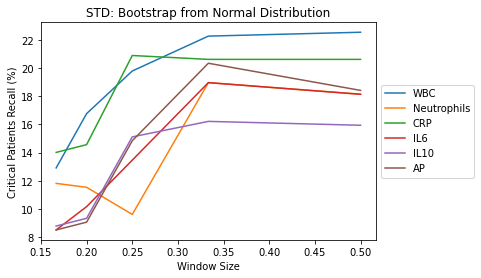

In [184]:
folder = '../results/plots/'
plt.figure(figsize=(8, 6))
cell_store['window'] = 1/np.array(windows)
cell_store_df = pd.DataFrame(cell_store)

if params['method'] ==  'distribution':
    cell_store_df.plot(x='window', ylabel='Critical Patients Recall (%)', xlabel='Window Size',
                       title='STD: Bootstrap from Normal Distribution')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    # plt.tight_layout()
    plt.savefig(folder + ews + '_bootstrap_distribution.png',
                dpi=300,  bbox_inches='tight')
    
elif params['method'] ==  'sampling':
    cell_store_df.plot(x='window', ylabel='Critical Patients Recall (%)', xlabel='Window Size',
                   title='STD: Bootstrap from Patient Samples')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    # plt.tight_layout()
    plt.savefig(folder + ews + '_bootstrap_patients.png',
                dpi=300,  bbox_inches='tight')

elif params['method'] ==  'none':
    cell_store_df.plot(x='window', ylabel='Critical Patients Recall (%)', xlabel='Window Size',
                   title='STD: No Imputing')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#     plt.tight_layout()
    plt.savefig(folder + ews + 'none.png',
                dpi=300,  bbox_inches='tight')

## AR

In [171]:
# Critical Patients
params = {
    'mu': 'mean',
    'sigma': 'std',
    'day_col': 'days_since_admission',
    'pat_col': 'ICU_ID_from_datasource',
    'method': 'sampling'
#     'method': 'distribution'
}

ews = 'ar'

df = df_critical.copy()
windows = [2, 3, 4, 5, 6]
cell_store = {}

for cell in dic.values():
    cell_store[cell] = []
    print(' ')
    print("Cell : ", cell)
    for win in windows:
        print(f'   For window size: {win}')
        df_group_cell = group_dataframes(
            df, cell, time, agg_list=['mean', 'std'])

        # trim
        df_cell = df[[cell, params['pat_col'], params['day_col']]]
        df_cell_boot = df_cell.apply(lambda row: bootstrap(row,
                                                           df_cell, df_group_cell, cell, params), axis=1)
        critical_count = 0
        patients = set(df_cell_boot[params['pat_col']])
        for patient in patients:
            df_pat = df_cell_boot[df_cell_boot[params['pat_col']] == patient]
            df_pat = df_pat.drop(params['pat_col'], axis=1)
            df_pat = df_pat.dropna().reset_index()
            # just get the residuals
            diff = pd.DataFrame(difference(df_pat[cell]))
        #     orig = method(data[immune], data[time], win_size)
        #     resid = method(diff, data[time], win_size)
            ts = do_ews_ar(diff, time='time', win_size=len(df_pat)/win)
            try:
                mkt_result = do_mann_kendall('noise_name', ts, "Original")
                if mkt_result.trend != 'no trend':
                    critical_count += 1
            except ZeroDivisionError:
                #             print ("ZeroDivisionError")
                continue
        recall = critical_count*100/len(patients)
        cell_store[cell].append(recall)
        print(f'   Critical Patients: {recall}')

 
Cell :  WBC
   For window size: 2


   Critical Patients: 12.912087912087912
   For window size: 3


   Critical Patients: 8.241758241758241
   For window size: 4


   Critical Patients: 6.868131868131868
   For window size: 5


   Critical Patients: 3.5714285714285716
   For window size: 6


   Critical Patients: 2.197802197802198
 
Cell :  Neutrophils
   For window size: 2


   Critical Patients: 0.8241758241758241
   For window size: 3


   Critical Patients: 0.8241758241758241
   For window size: 4


   Critical Patients: 0.5494505494505495
   For window size: 5


   Critical Patients: 0.5494505494505495
   For window size: 6


   Critical Patients: 0.27472527472527475
 
Cell :  CRP
   For window size: 2


   Critical Patients: 13.186813186813186
   For window size: 3


   Critical Patients: 9.065934065934066
   For window size: 4


   Critical Patients: 7.417582417582418
   For window size: 5


   Critical Patients: 4.1208791208791204
   For window size: 6


   Critical Patients: 3.5714285714285716
 
Cell :  IL6
   For window size: 2


   Critical Patients: 0.27472527472527475
   For window size: 3


   Critical Patients: 0.0
   For window size: 4


   Critical Patients: 0.0
   For window size: 5


   Critical Patients: 0.0
   For window size: 6


   Critical Patients: 0.0
 
Cell :  IL10
   For window size: 2


   Critical Patients: 0.0
   For window size: 3


   Critical Patients: 0.0
   For window size: 4


   Critical Patients: 0.0
   For window size: 5


   Critical Patients: 0.0
   For window size: 6


   Critical Patients: 0.0
 
Cell :  AP
   For window size: 2


   Critical Patients: 3.021978021978022
   For window size: 3


   Critical Patients: 2.4725274725274726
   For window size: 4


   Critical Patients: 1.6483516483516483
   For window size: 5


   Critical Patients: 1.6483516483516483
   For window size: 6


   Critical Patients: 0.27472527472527475


<Figure size 576x432 with 0 Axes>

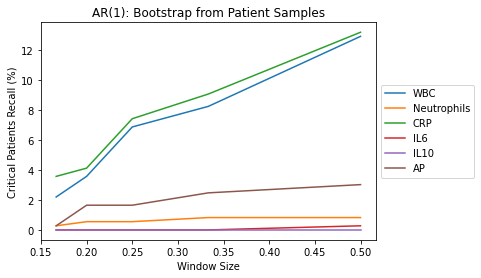

In [172]:
folder = '../results/plots/'
plt.figure(figsize=(8, 6))
cell_store['window'] = 1/np.array(windows)
cell_store_df = pd.DataFrame(cell_store)

if params['method'] == 'distribution':
    cell_store_df.plot(x='window', ylabel='Critical Patients Recall (%)', xlabel='Window Size',
                       title='AR(1): Bootstrap from Normal Distribution')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    # plt.tight_layout()
    plt.savefig(folder + ews + '_bootstrap_distribution.png',
                dpi=300,  bbox_inches='tight')

elif params['method'] == 'sampling':
    cell_store_df.plot(x='window', ylabel='Critical Patients Recall (%)', xlabel='Window Size',
                       title='AR(1): Bootstrap from Patient Samples')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    # plt.tight_layout()
    plt.savefig(folder + ews + '_bootstrap_patients.png',
                dpi=300,  bbox_inches='tight')